# AR and MA models for Sunspots

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#### 1. Download, import and prepare the dataset (cf. sunspots.ipynb).

In [2]:
# Loading the Data
df = pd.read_csv('SN_m_tot_V2.0.csv', sep=';',header=None)
# convert 'date' to datetime64
df['date'] = pd.to_datetime(df.loc[:,0].astype(str) + df.loc[:,1].astype(str), format='%Y%m')
df['spots'] = df.loc[:,3]
# keep only date and spots
df = df.loc[:,['date', 'spots']]
# observations of the last 100 years 
df1 = df[(df['date'] > '1924-04-01') & (df['date'] <= '2024-04-01')].copy()
df1['spots_diff_1'] = df1.spots.diff()
spots = df1.set_index('date')[['spots_diff_1']].dropna()
spots

,spots_diff_1
date,
1924-06-01,5.4
1924-07-01,6.9
1924-08-01,-14.8
1924-09-01,9.8
1924-10-01,0.7
...,...
2023-12-01,6.4
2024-01-01,9.5
2024-02-01,1.7


#### 2. Use a PACF plot to determine the order p of the AR(p) model

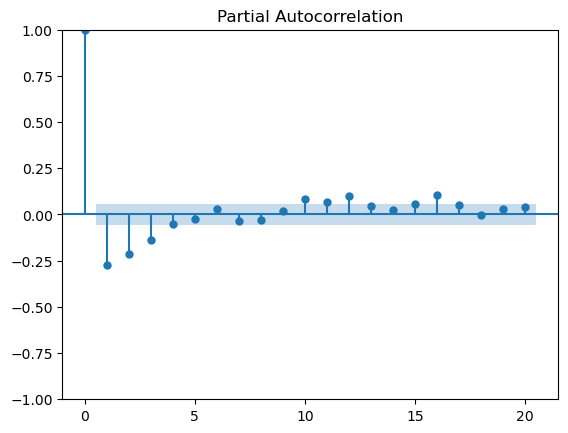

In [3]:
# PACF plot
plot_pacf(spots, lags=20)
plt.show()

We choose $p=3$.

#### 3. Fit an AR(p) model

In [4]:
# Fit an AR(3) model to the time series
sunAR3 = AutoReg(spots, lags=3).fit()
print(sunAR3.summary())

                            AutoReg Model Results                             
Dep. Variable:           spots_diff_1   No. Observations:                 1199
Model:                     AutoReg(3)   Log Likelihood               -5524.262
Method:               Conditional MLE   S.D. of innovations             24.533
Date:                Fri, 12 Sep 2025   AIC                          11058.524
Time:                        13:20:59   BIC                          11083.958
Sample:                    09-01-1924   HQIC                         11068.107
                         - 04-01-2024                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1335      0.709      0.188      0.851      -1.257       1.524
spots_diff_1.L1    -0.3605      0.029    -12.585      0.000      -0.417      -0.304
spots_diff_1.L2    -0.2604      

/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### 4. Perform model diagnostics for this model

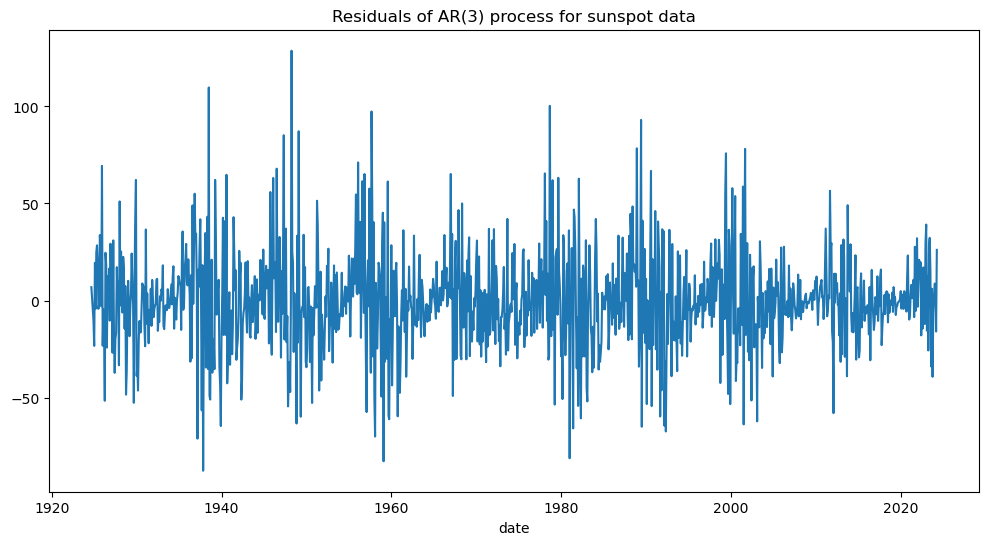

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(sunAR3.resid)
plt.title('Residuals of AR(3) process for sunspot data')
plt.show()

We see some seasonality in the residuals.

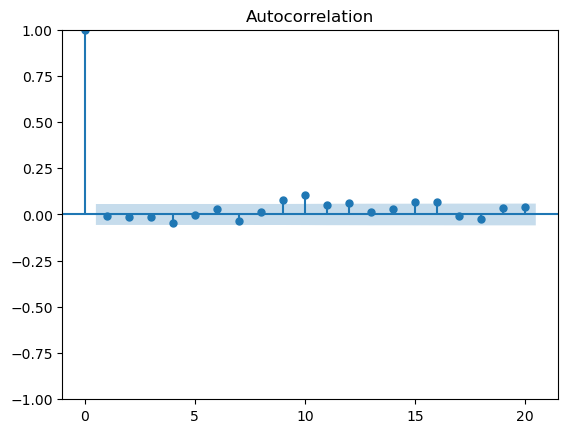

In [6]:
# ACF and PACF of residuals to check if they resemble white noise
plot_acf(sunAR3.resid, lags=20)
plt.show()

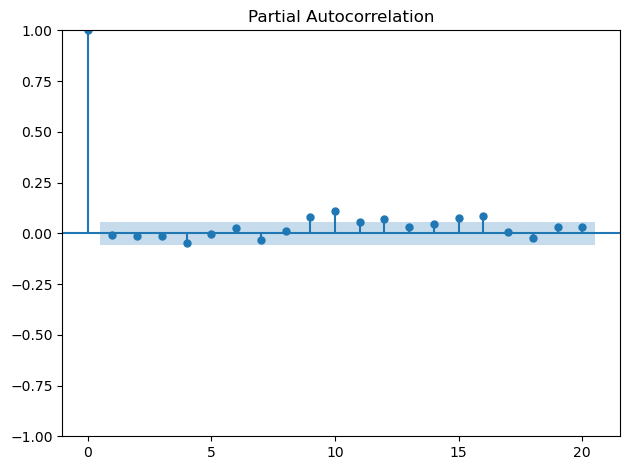

In [7]:
plot_pacf(sunAR3.resid, lags=20)
plt.tight_layout()
plt.show()

Some of the correlations are differ significantly from zero. The model fit is not perfect.

In [8]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(sunAR3.resid)

,lb_stat,lb_pvalue
1,0.054960,0.814647
2,0.277941,0.870254
3,0.471771,0.925048
4,2.928763,0.569817
5,2.944082,0.708607
6,4.019780,0.674000
7,5.362038,0.615873
8,5.569680,0.695308
9,13.412327,0.144819
10,27.254217,0.002374


The small p-value for lag 10 suggest the model is not adequate.

#### 5. Use an ACF plot to determine the order q of the MA(q) model

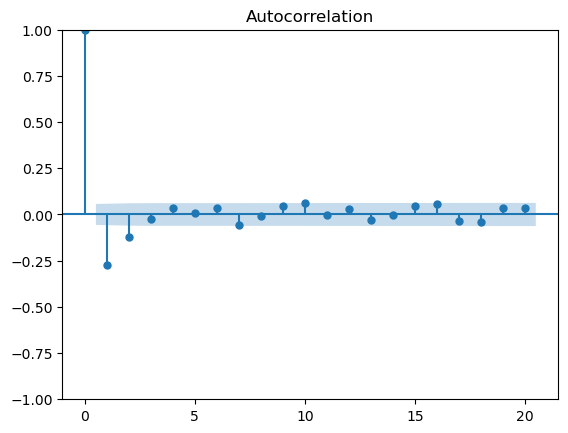

In [9]:
# PACF plot
plot_acf(spots, lags=20)
plt.show()

We choose $q=2$.

#### 6. Fit an MA(q) model

In [10]:
# Fit an MA(2) Model
sunMA2 = ARIMA(spots, order=(0, 0, 2)).fit()
print(sunMA2.summary())

/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/envs/statistik/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           spots_diff_1   No. Observations:                 1199
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -5537.189
Date:                Fri, 12 Sep 2025   AIC                          11082.378
Time:                        13:21:00   BIC                          11102.735
Sample:                    06-01-1924   HQIC                         11090.046
                         - 04-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0681      0.370      0.184      0.854      -0.657       0.793
ma.L1         -0.3644      0.024    -15.323      0.000      -0.411      -0.318
ma.L2         -0.1264      0.024     -5.338      0.0

#### 7. Perform model diagnostics for this model

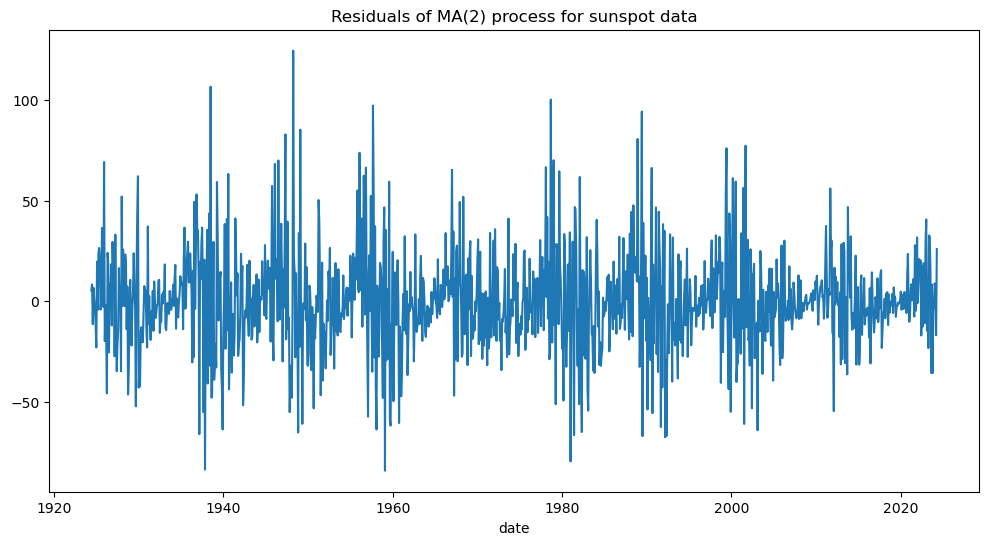

In [11]:
plt.figure(figsize=(12, 6))
sns.lineplot(sunMA2.resid)
plt.title('Residuals of MA(2) process for sunspot data')
plt.show()

Again we see some seasonality in the residuals.

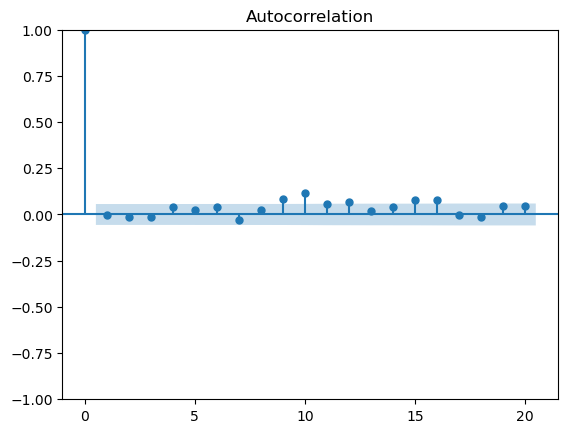

In [12]:
# ACF and PACF of residuals to check if they resemble white noise
plot_acf(sunMA2.resid, lags=20)
plt.show()

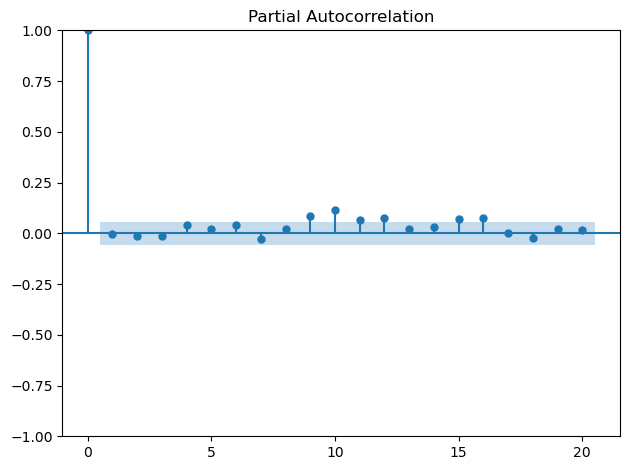

In [13]:
plot_pacf(sunMA2.resid, lags=20)
plt.tight_layout()
plt.show()

Some of the correlations differ significantly from zero. The model fit is not perfect.

In [14]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(sunMA2.resid)

,lb_stat,lb_pvalue
1,0.006503,0.935728
2,0.273915,0.872007
3,0.515689,0.915431
4,2.587568,0.629027
5,3.247295,0.661920
6,5.006268,0.543009
7,5.978760,0.542232
8,6.546173,0.586291
9,15.256492,0.084127
10,31.232380,0.000537


The small p-value for lag 10 suggest the model is not adequate.

#### 8. Use AIC to compare the two models

In [15]:
print(f'AIC for AR(3): {sunAR3.aic}')
print(f'AIC for MA(2): {sunMA2.aic}')

AIC for AR(3): 11058.524391840005
AIC for MA(2): 11082.377724635784


The AR(3) model has the lower AIC. However, the diagnostics suggest that the model does not fit well.